### 데이터 의미

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [22]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm.auto import tqdm
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('./data/train.csv').drop(columns='id')
df_test = pd.read_csv('./data/test.csv').drop(columns='id')

print(df_train.shape, df_test.shape)

(15035, 20) (6468, 19)


### EDA

In [23]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

## 결측치는 하나도 없다.

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


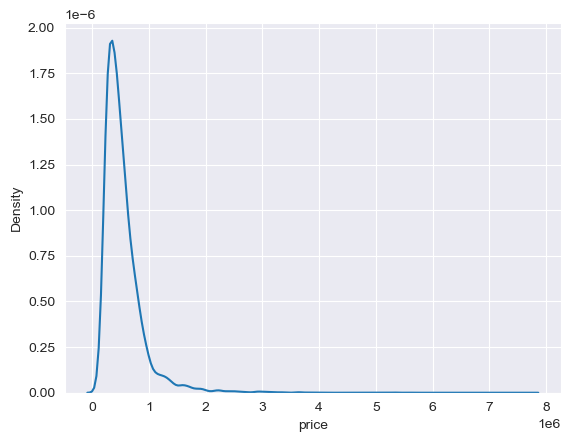

In [29]:
sns.kdeplot(df_train['price'])
plt.show()

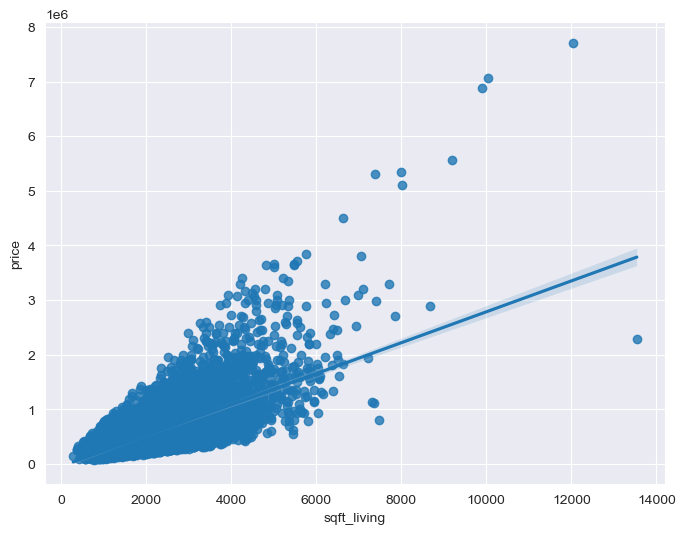

In [24]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

## sqft_living이 커질수록 price의 범위가 커진다.
## 평당 가격으로 전환해서 예측하면 분포가 더 안정적으로 바뀔 듯

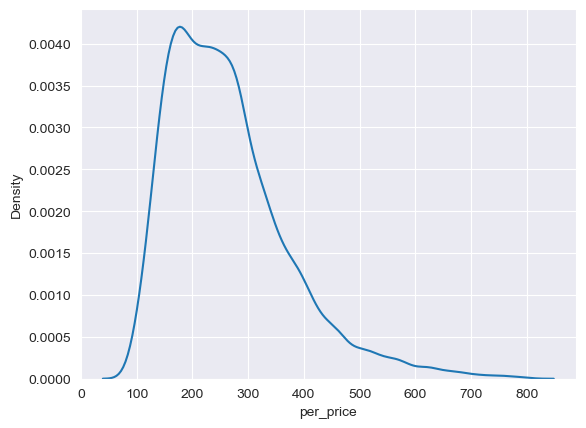

In [30]:
df_train['per_price'] = df_train['price'] / df_train['sqft_living']

sns.kdeplot(df_train['per_price'])
plt.show()

## 이전보다 더 정규분포에 가까워짐

<Axes: >

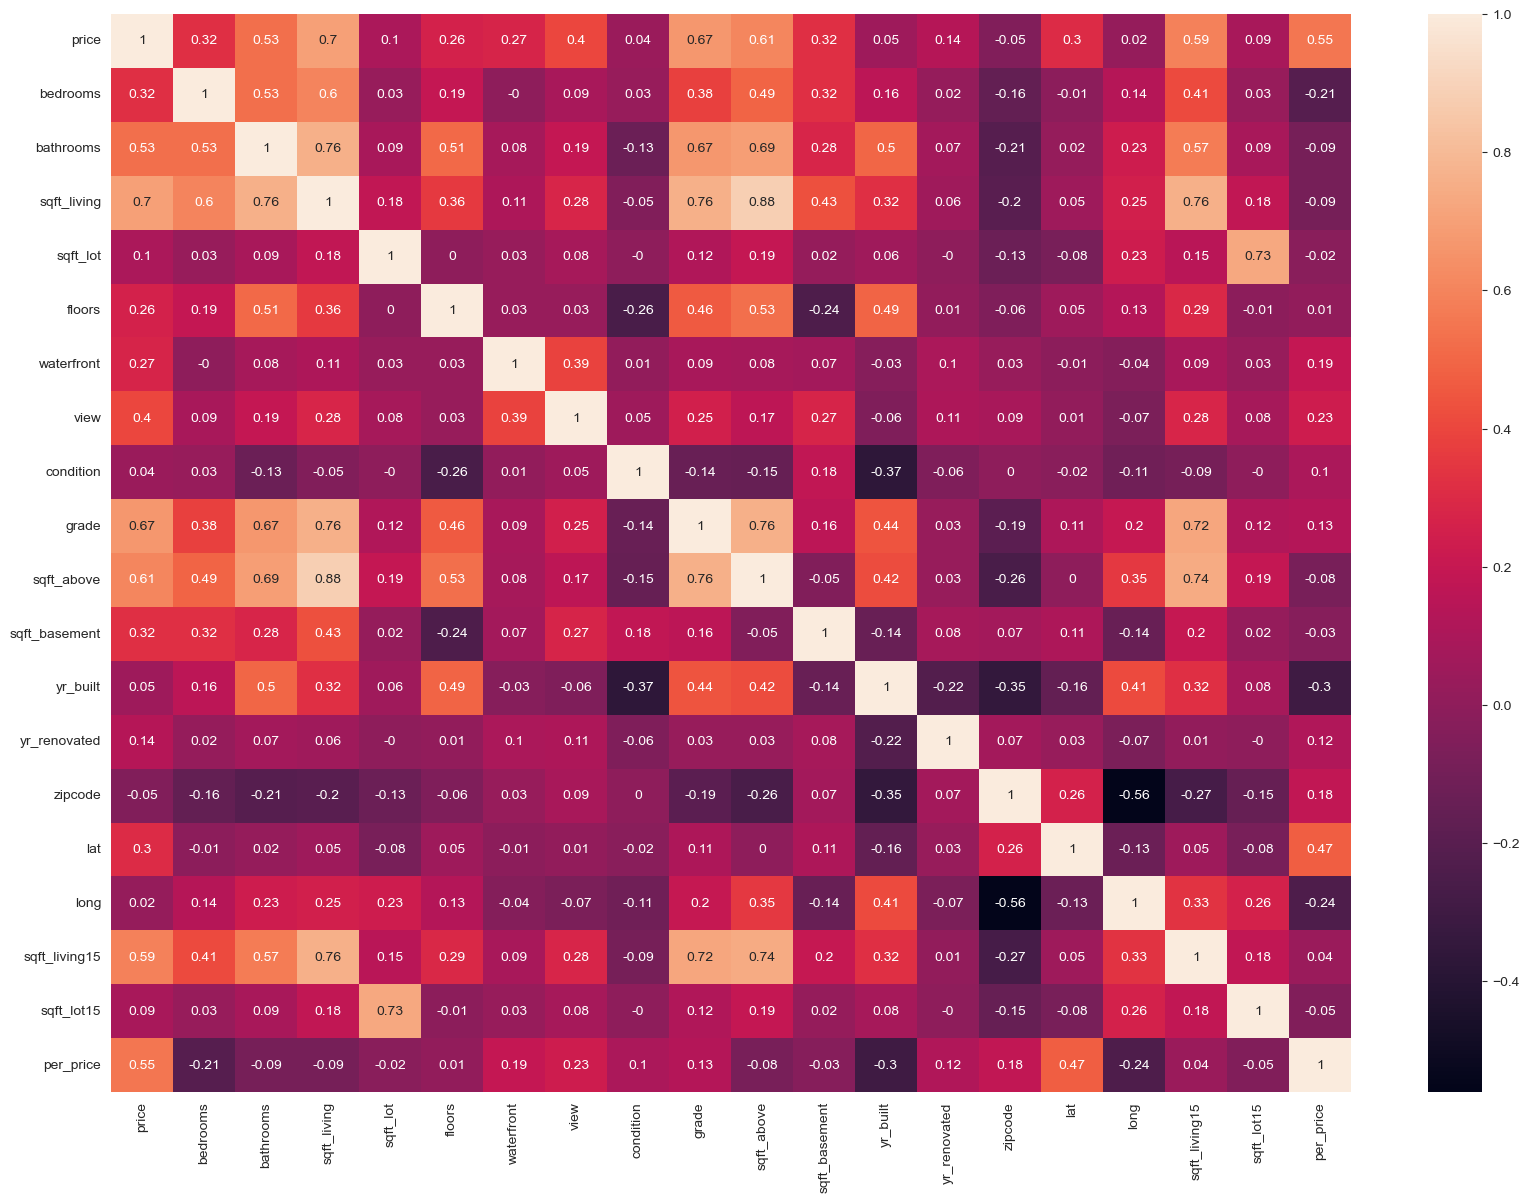

In [31]:
plt.figure(figsize=(20,14))
sns.heatmap(df_train.drop(columns='date').corr().round(2), annot = True)

## 상관계수가 가장 높은게 0.88 >> 공분산성에 문제되는 데이터는 없는 것으로 보임
## lgbm, xgb는 공분산성에서 안전한 편이기도 함

### 전처리

In [9]:
# date에서 year 추출

for df in [df_train, df_test]:
	df['sale_yr'] = pd.to_numeric(df.date.str.slice(0, 4))
	df.drop(['date'], axis=1, inplace=True)

In [10]:
for df in [df_train, df_test]:
	#재건축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x < 0 else 1)

    # 용적률 주거 공간 / 대지 면적
    df['far1'] = df['sqft_living'] / (df['sqft_lot'] + 1)

    # 층당 화장실 개수
    df['bath_per_floors'] = df['bathrooms'] / (df['floors'] + 1)

    # 방당 화장실 개수
    df['bath_per_rooms'] = df['bathrooms'] / (df['bedrooms'] + 1)

    ## 0으로 나눠지는 것을 방지
    ## 0으로 나누면 NaN(결측)으로 표시되지만, 실제로는 무한대라는 값이 들어가있어 머신러닝을 학습할 수 없음.
    ## XGB, LGBM같은 머신러닝은 결측치를 자체적으로 처리함. (0으로 처리 or 결측 그 자체로 처리)

In [11]:
# 지역별로 평당가격의 평균을 추가

df_train['per_price'] = df_train['price'] / df_train['sqft_living']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean'}).reset_index()
df_train = pd.merge(df_train, zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test, zipcode_price,how='left',on='zipcode')

In [12]:
categorical_cols = [
    'zipcode'
]

### 파라미터 튜닝

In [59]:
def objective(trial):
    params_xgb = {
        'n_jobs': 12,
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        'enable_categorical': True,
        'learning_rate': trial.suggest_float('xgb_learning_rate', 1e-3, 0.1, log=True),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('xgb_lambda', 1e-8, 1.0, log=True), # L2
        'alpha': trial.suggest_float('xgb_alpha', 1e-8, 1.0, log=True),   # L1
    }

    seed_val_rmse_list = []
    seed_list = [777, 2025, 333] # 재현성 확보 + seed 앙상블

    for seed in seed_list:
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)

        val_rmse_list = []
        for fold, (train_idx, valid_idx) in enumerate(kf.split(df_train)):
            train_fold = df_train.loc[train_idx].copy().reset_index(drop=True)
            valid_fold = df_train.loc[valid_idx].copy().reset_index(drop=True)
            test_fold = df_test.copy().reset_index(drop=True)

            X_train, y_train = train_fold.drop(columns=['price', 'sqft_living', 'per_price']), train_fold['per_price']
            X_valid, y_valid = valid_fold.drop(columns=['price', 'sqft_living', 'per_price']), valid_fold['per_price']
            X_test = test_fold.drop(columns=['sqft_living'])

            # 범주형 변수 처리
            if len(categorical_cols) > 0:
                X_train[categorical_cols] = X_train[categorical_cols].astype('category')
                X_valid[categorical_cols] = X_valid[categorical_cols].astype('category')
                X_test[categorical_cols] = X_test[categorical_cols].astype('category')

            # 각 모델의 random_state를 현재 루프의 seed로 설정하여 일관성 유지
            params_xgb['random_state'] = seed
            model_xgb = XGBRegressor(**params_xgb)

            model_xgb.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                verbose=False,
            )

            val_probs = model_xgb.predict(X_valid)
            val_probs = val_probs * valid_fold['sqft_living']

            val_rmse = root_mean_squared_error(valid_fold['price'], val_probs)
            val_rmse_list.append(val_rmse)

        val_seed_rmse = np.mean(val_rmse_list, axis=0)
        seed_val_rmse_list.append(val_seed_rmse)

    val_avg_rmse = np.mean(seed_val_rmse_list, axis=0)
    print(f'[Trial] AVG Valid RMSE: {val_avg_rmse:.4f}\n')

    return val_avg_rmse



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 최적화 결과 출력
print("=" * 50)
print("Optuna 최적화 종료")
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value (minimized RMSE): ", best_trial.value)
print("  Best Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-18 16:17:01,973] A new study created in memory with name: no-name-c35eaee1-d977-495e-9cbc-098537a6f8f1


  0%|          | 0/50 [00:00<?, ?it/s]

[Trial] AVG Valid RMSE: 113380.8784

[I 2025-07-18 16:17:04,992] Trial 0 finished with value: 113380.87842526483 and parameters: {'xgb_learning_rate': 0.021481692029389376, 'xgb_max_depth': 3, 'xgb_min_child_weight': 1, 'xgb_subsample': 0.8274182576196772, 'xgb_colsample_bytree': 0.6495199686366601, 'xgb_gamma': 2.0499000849313008e-08, 'xgb_lambda': 0.46606896537687864, 'xgb_alpha': 1.2698449096417438e-08}. Best is trial 0 with value: 113380.87842526483.
[Trial] AVG Valid RMSE: 119289.7948

[I 2025-07-18 16:17:07,099] Trial 1 finished with value: 119289.79475415968 and parameters: {'xgb_learning_rate': 0.0024345786771125073, 'xgb_max_depth': 5, 'xgb_min_child_weight': 3, 'xgb_subsample': 0.5190353562006649, 'xgb_colsample_bytree': 0.807269523555544, 'xgb_gamma': 3.104179961286129e-05, 'xgb_lambda': 0.003864592175640996, 'xgb_alpha': 0.014626022052605114}. Best is trial 0 with value: 113380.87842526483.
[Trial] AVG Valid RMSE: 118548.1784

[I 2025-07-18 16:17:10,022] Trial 2 finished wi

In [14]:
def objective(trial):
    params_lgbm = {
        'n_jobs': -1,
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        'enable_categorical': True,
        'verbosity': -1,
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 1e-3, 0.1, log=True),
        'max_depth': trial.suggest_int('lgbm_max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('lgbm_min_child_weight', 1, 10),
        'subsample': trial.suggest_float('lgbm_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('lgbm_colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('lgbm_gamma', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lgbm_lambda', 1e-8, 1.0, log=True), # L2
        'alpha': trial.suggest_float('lgbm_alpha', 1e-8, 1.0, log=True),   # L1
    }

    seed_val_rmse_list = []
    seed_list = [777, 2025, 333] # 재현성 확보 + seed 앙상블

    for seed in seed_list:
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)

        val_rmse_list = []
        for fold, (train_idx, valid_idx) in enumerate(kf.split(df_train)):
            train_fold = df_train.loc[train_idx].copy().reset_index(drop=True)
            valid_fold = df_train.loc[valid_idx].copy().reset_index(drop=True)
            test_fold = df_test.copy().reset_index(drop=True)

            X_train, y_train = train_fold.drop(columns=['price', 'sqft_living', 'per_price']), train_fold['per_price']
            X_valid, y_valid = valid_fold.drop(columns=['price', 'sqft_living', 'per_price']), valid_fold['per_price']
            X_test = test_fold.drop(columns=['sqft_living'])

            # 범주형 변수 처리
            if len(categorical_cols) > 0:
                X_train[categorical_cols] = X_train[categorical_cols].astype('category')
                X_valid[categorical_cols] = X_valid[categorical_cols].astype('category')
                X_test[categorical_cols] = X_test[categorical_cols].astype('category')

            # 각 모델의 random_state를 현재 루프의 seed로 설정하여 일관성 유지
            params_lgbm['random_state'] = seed
            model_lgbm = LGBMRegressor(**params_lgbm)

            model_lgbm.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
            )

            val_probs = model_lgbm.predict(X_valid)
            val_probs = val_probs * valid_fold['sqft_living']

            val_rmse = root_mean_squared_error(valid_fold['price'], val_probs)
            val_rmse_list.append(val_rmse)

        val_seed_rmse = np.mean(val_rmse_list, axis=0)
        seed_val_rmse_list.append(val_seed_rmse)

    val_avg_rmse = np.mean(seed_val_rmse_list, axis=0)
    print(f'[Trial] AVG Valid RMSE: {val_avg_rmse:.4f}\n')

    return val_avg_rmse



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# 최적화 결과 출력
print("=" * 50)
print("Optuna 최적화 종료")
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value (minimized RMSE): ", best_trial.value)
print("  Best Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-18 16:45:15,373] A new study created in memory with name: no-name-c1112885-da38-4d53-811b-cd8563d55b51


  0%|          | 0/50 [00:00<?, ?it/s]

[Trial] AVG Valid RMSE: 109073.6741

[I 2025-07-18 16:46:03,927] Trial 0 finished with value: 109073.67411034585 and parameters: {'lgbm_learning_rate': 0.00701030593482764, 'lgbm_max_depth': 5, 'lgbm_min_child_weight': 9, 'lgbm_subsample': 0.5576442749271349, 'lgbm_colsample_bytree': 0.9928186616460751, 'lgbm_gamma': 0.004101839589294308, 'lgbm_lambda': 0.0014575195436733357, 'lgbm_alpha': 0.0002693139441241905}. Best is trial 0 with value: 109073.67411034585.
[Trial] AVG Valid RMSE: 108516.0308

[I 2025-07-18 16:46:44,721] Trial 1 finished with value: 108516.03077163438 and parameters: {'lgbm_learning_rate': 0.008930623927097514, 'lgbm_max_depth': 5, 'lgbm_min_child_weight': 8, 'lgbm_subsample': 0.756413973857071, 'lgbm_colsample_bytree': 0.6928358855688523, 'lgbm_gamma': 0.027569492219657026, 'lgbm_lambda': 0.0011159788568653594, 'lgbm_alpha': 0.003929826522074666}. Best is trial 1 with value: 108516.03077163438.
[Trial] AVG Valid RMSE: 111502.6821

[I 2025-07-18 16:48:29,032] Trial 

KeyboardInterrupt: 

### 학습

In [15]:
params_xgb = {
    'n_jobs': -1,
    'n_estimators': 10000,
    'early_stopping_rounds': 100,
    'enable_categorical': True,
    'learning_rate': 0.005142058632413704,
    'max_depth': 3,
    'min_child_weight': 9,
    'subsample': 0.9990368039546952,
    'colsample_bytree': 0.787507440535618,
    'gamma': 1.1963362984339293e-07,
    'lambda': 0.01593071938603482,
    'alpha': 0.07964866406085315,
}

params_lgbm = {
    'n_jobs': -1,
    'n_estimators': 10000,
    'early_stopping_rounds': 100,
    'enable_categorical': True,
    'verbosity': -1,
    'learning_rate'': 0.003751773140679701,'
    'max_depth': 7,
    'min_child_weight': 7,
    'subsample': 0.8974218086359345,
    'colsample_bytree': 0.5651244089694295,
    'gamma': 1.2391167452644335e-06,
    'lambda': 3.209636845199594e-05,
    'alpha': 7.319492482287846e-08,
}


seed_pred_list = []
seed_val_rmse_list = []
seed_list = [777, 2025, 333] # 재현성 확보 + seed 앙상블

for seed in seed_list:
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    val_rmse_list = []
    test_pred_list = []
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df_train)):
        train_fold = df_train.loc[train_idx].copy().reset_index(drop=True)
        valid_fold = df_train.loc[valid_idx].copy().reset_index(drop=True)
        test_fold = df_test.copy().reset_index(drop=True)

        X_train, y_train = train_fold.drop(columns=['price', 'sqft_living', 'per_price']), train_fold['per_price']
        X_valid, y_valid = valid_fold.drop(columns=['price', 'sqft_living', 'per_price']), valid_fold['per_price']
        X_test = test_fold.drop(columns=['sqft_living'])

        # 범주형 변수 처리
        if len(categorical_cols) > 0:
            X_train[categorical_cols] = X_train[categorical_cols].astype('category')
            X_valid[categorical_cols] = X_valid[categorical_cols].astype('category')
            X_test[categorical_cols] = X_test[categorical_cols].astype('category')

        # 각 모델의 random_state를 현재 루프의 seed로 설정하여 일관성 유지
        params_xgb['random_state'] = seed
        params_lgbm['random_state'] = seed
        model_xgb = XGBRegressor(**params_xgb)
        model_lgbm = LGBMRegressor(**params_lgbm)

        model_xgb.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        )

        model_lgbm.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
        )

        val_probs_xgb = model_xgb.predict(X_valid)
        val_probs_lgbm = model_lgbm.predict(X_valid)
        val_probs = np.mean([
            val_probs_lgbm,
            val_probs_xgb
        ], axis=0)
        val_probs = val_probs * valid_fold['sqft_living']

        val_rmse = root_mean_squared_error(valid_fold['price'], val_probs)
        print(f'[Seed {seed} Fold {fold+1}] Val RMSE: {val_rmse:.4f}')

        val_rmse_list.append(val_rmse)

        test_probs_xgb = model_xgb.predict(X_test)
        test_probs_lgbm = model_lgbm.predict(X_test)
        test_probs = np.mean([
            test_probs_xgb,
            test_probs_lgbm
        ], axis=0)
        test_probs = test_probs * test_fold['sqft_living'] # 평당 가격에서 다시 원래 price로 복원

        test_pred_list.append(test_probs)

    val_seed_rmse = np.mean(val_rmse_list, axis=0)
    seed_val_rmse_list.append(val_seed_rmse)

    seed_pred_list.append(np.mean(test_pred_list, axis=0))

val_avg_rmse = np.mean(seed_val_rmse_list, axis=0)
print(f'[Trial] AVG Valid RMSE: {val_avg_rmse:.4f}\n')

[Seed 777 Fold 1] Val RMSE: 109600.2169
[Seed 777 Fold 2] Val RMSE: 95918.6208
[Seed 777 Fold 3] Val RMSE: 102432.6358
[Seed 777 Fold 4] Val RMSE: 112378.5909
[Seed 777 Fold 5] Val RMSE: 111994.8582
[Seed 2025 Fold 1] Val RMSE: 112888.6303
[Seed 2025 Fold 2] Val RMSE: 99783.2894
[Seed 2025 Fold 3] Val RMSE: 102016.4158
[Seed 2025 Fold 4] Val RMSE: 110279.0163
[Seed 2025 Fold 5] Val RMSE: 110873.2137
[Seed 333 Fold 1] Val RMSE: 119546.2514
[Seed 333 Fold 2] Val RMSE: 108047.7983
[Seed 333 Fold 3] Val RMSE: 113900.5026
[Seed 333 Fold 4] Val RMSE: 97153.1451
[Seed 333 Fold 5] Val RMSE: 109164.0000
[Trial] AVG Valid RMSE: 107731.8124



In [16]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['price'] = np.mean(seed_pred_list, axis=0)

submission.to_csv('./submission/baseline.csv', index=False)

submission

,id,price
0,15035,5.195642e+05
1,15036,5.081266e+05
2,15037,1.342780e+06
3,15038,3.172036e+05
4,15039,3.250449e+05
...,...,...
6463,21498,2.903185e+05
6464,21499,4.824495e+05
6465,21500,4.845925e+05
6466,21501,3.310269e+05
